# Project 2: Image Processing - Identifying Road Segment From Satellite Images

This jupyter notebook contains our journey to train a model ...

Dataset can be downloaded [here](https://www.aicrowd.com/challenges/epfl-ml-road-segmentation/dataset_files).

**Authors:** : [Luca Carroz](https://people.epfl.ch/emilie.carroz), [David Schroeter](https://people.epfl.ch/david.schroeter), [Paulo Ribeiro de Carvalho](https://people.epfl.ch/paulo.ribeirodecarvalho)

<hr style="clear:both">

## Import

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
from sklearn import linear_model

from utils.feature_extraction import *
from utils.helpers import *
from utils.lin_reg_crossvalidation import *
from utils.mask_to_submission import *
import numpy as np

## Load Data

In [2]:
# Set the paths to the images to load
training_folder_path = "dataset/training"
testing_folder_path = "dataset/test_set_images/"
images_path = training_folder_path + "/images/"
ground_truth_path = training_folder_path + "/groundtruth/"

# Load all the training and testing images and convert to numpy arrays
train_imgs = load_images(images_path)
train_arrays = [np.array(img) / 255 for img in train_imgs]
train_gt_imgs = load_images(ground_truth_path)
train_gt_arrays = [np.array(img) / 255 for img in train_gt_imgs]

test_imgs = load_images(testing_folder_path)
test_arrays = [np.array(img) / 255 for img in test_imgs]

## Exploratory Data Analysis

Number of train images : 100
Train image's dimensions : (400, 400, 3)
Train ground truth's dimensions : (400, 400)
Number of test images : 50
Test image's dimensions : (608, 608, 3)


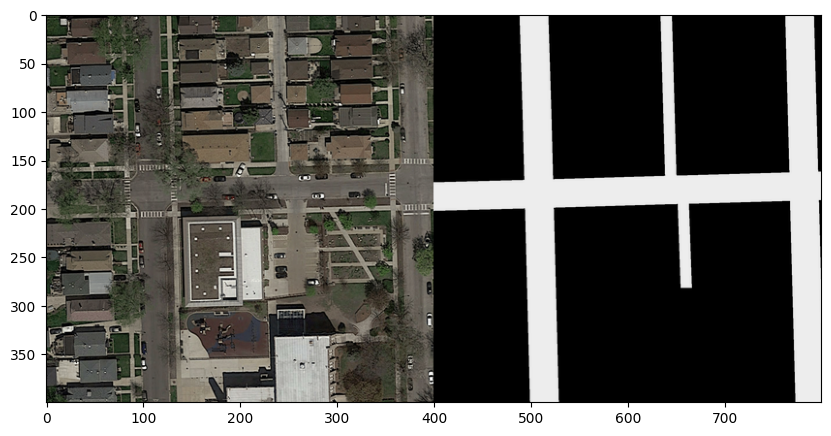

In [3]:
# How many images do we have ?
n_train = len(train_arrays)
n_test = len(test_arrays)

# What are the dimensions of each image ?
train_img_dim = train_arrays[0].shape
train_gt_dim = train_gt_arrays[0].shape
test_img_dim = test_arrays[0].shape


print(f"Number of train images : {n_train}\n"
      f"Train image's dimensions : {train_img_dim}\n"
      f"Train ground truth's dimensions : {train_gt_dim}\n"
      f"Number of test images : {n_test}\n"
      f"Test image's dimensions : {test_img_dim}")


# Select the paired images to see (image + ground truth)
i = 1
img_and_gt = concatenate_images(train_imgs[i], train_gt_imgs[i])

plt.figure(figsize=(10, 10))
plt.imshow(img_and_gt, cmap="Greys_r")
plt.show()

## Feature Processing

In order to perform a relevant logistic regression, we need to transform our images into features that can be used by the model. We thus divide each image in square 16 by 16 patches, and extract features from those patches

In [4]:
# Split images into 16 by 16 square patches
patch_size = 16
assert train_img_dim[0] % patch_size == 0 and train_img_dim[1] % patch_size == 0, "Patch size is not a divisor of the train image dimensions"
assert test_img_dim[0] % patch_size == 0 and test_img_dim[1] % patch_size == 0, "Patch size is not a divisor of the test image dimensions"

images_patches = np.array([extract_patches(img, patch_size, patch_size) for img in train_arrays])
ground_truth_patches = np.array([extract_patches(img, patch_size, patch_size) for img in train_gt_arrays])

print(f"Shape of unflattened image patches : {images_patches.shape}\n"
      f"Shape of unflattened ground truth patches : {ground_truth_patches.shape}")

# Flatten the patches
images_patches = np.reshape(images_patches, (-1, patch_size, patch_size, 3))
ground_truth_patches = np.reshape(ground_truth_patches, (-1, patch_size, patch_size))
print(f"Shape of flattened image patches : {images_patches.shape}\n"
      f"Shape of flattened ground truth patches : {ground_truth_patches.shape}")

Shape of unflattened image patches : (100, 625, 16, 16, 3)
Shape of unflattened ground truth patches : (100, 625, 16, 16)
Shape of flattened image patches : (62500, 16, 16, 3)
Shape of flattened ground truth patches : (62500, 16, 16)


Instead of simply giving those patches as input to our model, we will build some more relevant features. For each patch, we will compute some features such as the mean and the variance of the pixel intensity on those $16^2$ pixels

In [5]:
# the threshold is the fraction of road pixels required to define a patch as a road patch
threshold = 0.5
x = np.array([extract_features(image_patch) for image_patch in images_patches])
y = np.array([ground_truth_patch_to_int(ground_truth_patch, threshold) for ground_truth_patch in ground_truth_patches])
x.shape, y.shape

((62500, 6), (62500,))

In [6]:
# split the data into train and validation sets, according to the validation ratio
val_ratio = 0.15
split_idx = int(val_ratio * len(x))

np.random.seed(42)
indices = np.arange(len(x))
np.random.shuffle(indices)

x_train, x_val = x[indices[split_idx:]], x[indices[:split_idx]]
y_train, y_val = y[indices[split_idx:]], y[indices[:split_idx]]
x_train.shape, y_train.shape, x_val.shape, y_val.shape

((53125, 6), (53125,), (9375, 6), (9375,))

In [7]:
# normalize the data
mean = np.mean(x_train, axis=0)
std = np.std(x_train, axis=0)
x_train = (x_train - mean) / std
x_val = (x_val - mean) / std

In [8]:
# print feature statistics
print(f"Number of sample = {x_train.shape[0]}\n"
      f"Feature dimension = {x_train.shape[1]}\n"
      f"Number of classes = {len(np.unique(y_train))}\n")

Number of sample = 53125
Feature dimension = 6
Number of classes = 2


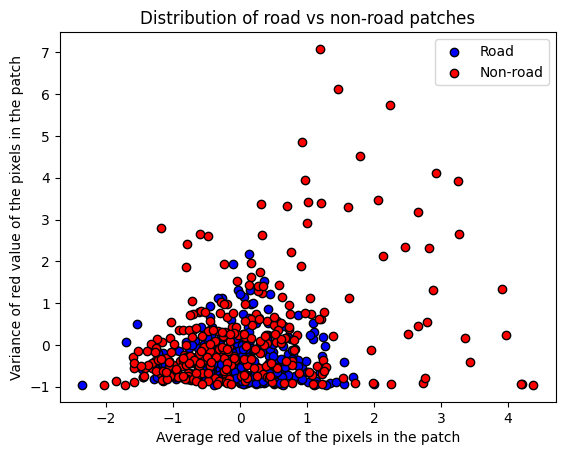

In [9]:
# plot the two classes with respect to the mean and the var of the first channel
plt.scatter(x_train[y_train == 1, 0][:300], x_train[y_train == 1, 4][:300], c='b', edgecolors="k", label='Road')
plt.scatter(x_train[y_train == 0, 0][:300], x_train[y_train == 0, 4][:300], c='r', edgecolors="k", label='Non-road')

plt.title("Distribution of road vs non-road patches")
plt.xlabel("Average red value of the pixels in the patch")
plt.ylabel("Variance of red value of the pixels in the patch")
plt.legend()
plt.show()

## Model
We will see how a linear regression performs on our data. We will use the `LogisticRegression` class from `sklearn.linear_model`. We will use the `f1_score` as a metric to evaluate our model. We will also use cross-validation to find the best parameters for our model.

In [10]:
# find the best parameters for our logistic regression
penalties = [None, 'l1', 'l2', 'elasticnet']
class_weights = [None, 'balanced'] + [{0: 1, 1:i} for i in range(3, 7)]

best_params, f1_score = lin_reg_best_params(penalties, class_weights, x_train, y_train)
print(f"Best parameters : {best_params}\n"
      f"f1 score : {f1_score}")

# fit the model with the best parameters
logreg = linear_model.LogisticRegression(C=best_params["C"], penalty=best_params["penalty"], class_weight=best_params["class_weight"], solver=best_params["solver"], l1_ratio=best_params["l1_ratio"], max_iter=1000)
logreg.fit(x_train, y_train)

Testing parameters: penalty=None, C=1, solver=lbfgs, class_weight=None, l1_ratio=0
Testing parameters: penalty=None, C=1, solver=lbfgs, class_weight=balanced, l1_ratio=0
Testing parameters: penalty=None, C=1, solver=lbfgs, class_weight={0: 1, 1: 3}, l1_ratio=0
Testing parameters: penalty=None, C=1, solver=lbfgs, class_weight={0: 1, 1: 4}, l1_ratio=0
Testing parameters: penalty=None, C=1, solver=lbfgs, class_weight={0: 1, 1: 5}, l1_ratio=0
Testing parameters: penalty=None, C=1, solver=lbfgs, class_weight={0: 1, 1: 6}, l1_ratio=0
Testing parameters: penalty=None, C=1, solver=newton-cg, class_weight=None, l1_ratio=0
Testing parameters: penalty=None, C=1, solver=newton-cg, class_weight=balanced, l1_ratio=0
Testing parameters: penalty=None, C=1, solver=newton-cg, class_weight={0: 1, 1: 3}, l1_ratio=0
Testing parameters: penalty=None, C=1, solver=newton-cg, class_weight={0: 1, 1: 4}, l1_ratio=0
Testing parameters: penalty=None, C=1, solver=newton-cg, class_weight={0: 1, 1: 5}, l1_ratio=0
Tes

LogisticRegression(C=71968.56730011529, class_weight={0: 1, 1: 4},
                   l1_ratio=0.8888888888888888, max_iter=1000,
                   penalty='elasticnet', solver='saga')

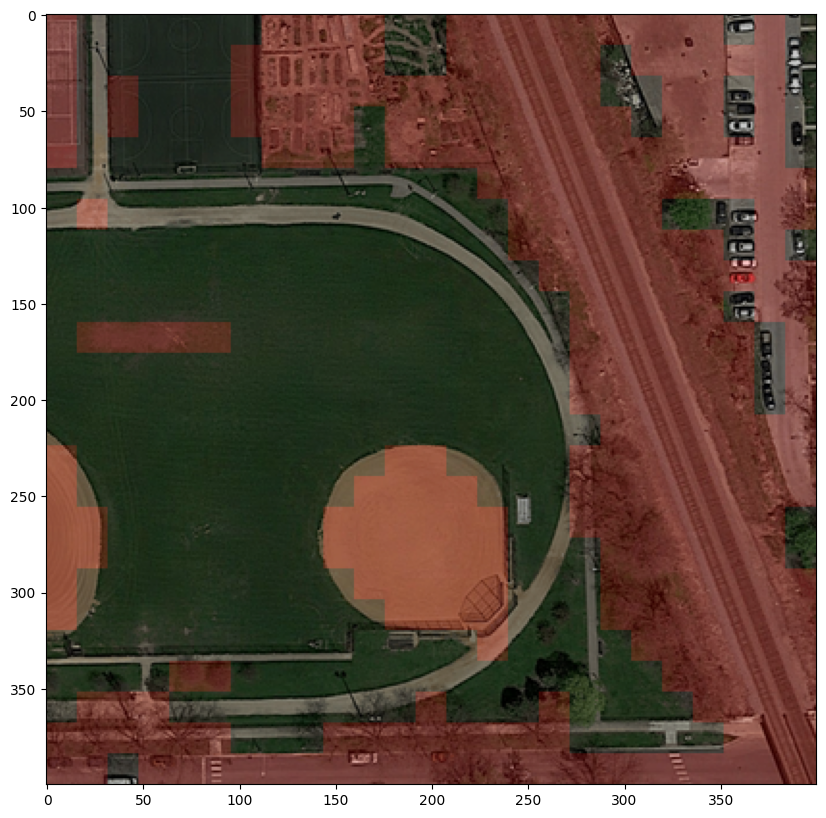

In [15]:
# let's see the prediction for a single image
sample_idx = 20
sample_img = train_arrays[sample_idx]
sample_x = (extract_images_features(np.array([sample_img]), patch_size) - mean) / std
#TODO: add normalization
sample_pred = logreg.predict(sample_x)
w, h = train_arrays[sample_idx].shape[:2]

sample_pred_img = label_to_img(w, h, patch_size, patch_size, sample_pred)
fig1 = plt.figure(figsize=(10, 10))  # create a figure with the default size

new_img = make_img_overlay(train_imgs[sample_idx], sample_pred_img)

plt.imshow(new_img)
plt.show()

## Predictions

In [17]:
# Compute predictions for the test set
x_test = (extract_images_features(test_arrays, patch_size) - mean) / std
test_predictions = logreg.predict(x_test)

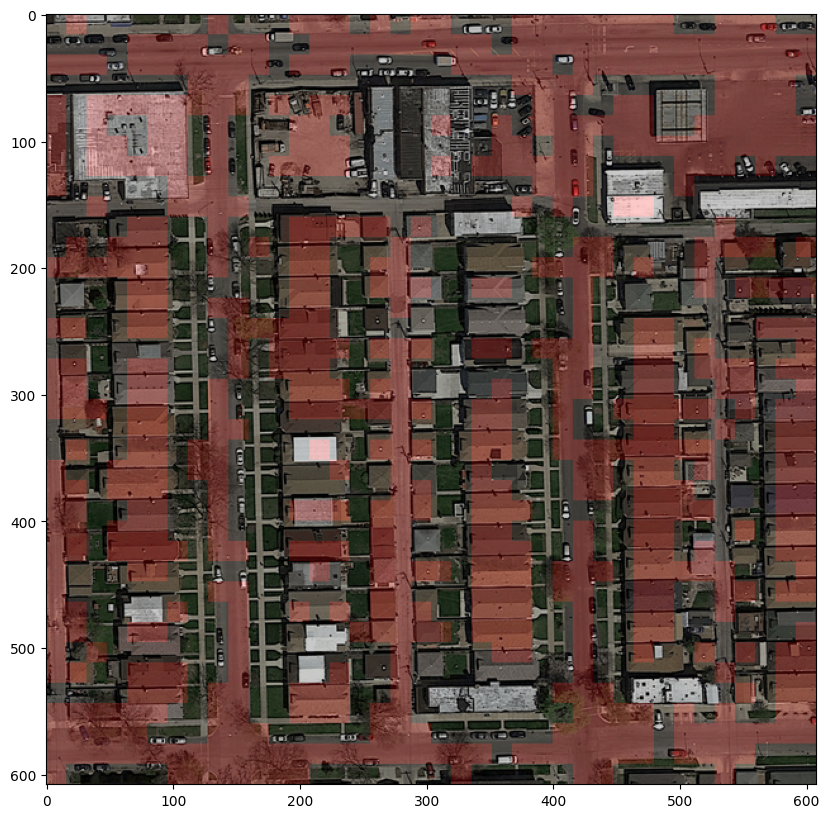

In [18]:
# Let's see the prediction for a single test image
w_test, h_test = test_arrays[0].shape[:2]
sqrt_n_patches = w_test // patch_size

sample_pred = test_predictions[:sqrt_n_patches**2]
sample_pred_img = label_to_img(w_test, h_test, patch_size, patch_size, sample_pred)

fig = plt.figure(figsize=(10, 10))
new_img = make_img_overlay(test_imgs[0], sample_pred_img)
plt.imshow(new_img)

In [14]:
# create submission file
array_to_submission('predictions.csv', test_predictions, sqrt_n_patches, patch_size)